In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt

In [81]:
## making data that is just wins so the model can reconise what a win looks like before learning about the game and also a loss
def generateConnect4Win(player=1, winType='horizontal'):
    numRows, numCols = 6, 7
    board = np.zeros((numRows, numCols), dtype=int)

    if winType == 'horizontal':
        startRow = random.randint(0, numRows - 1)
        startCol = random.randint(0, numCols - 4)
        board[startRow, startCol:startCol + 4] = player

    elif winType == 'vertical':
        startRow = random.randint(3, numRows - 1)
        startCol = random.randint(0, numCols - 1)
        board[startRow - 3:startRow + 1, startCol] = player

    elif winType == 'diagonalDown':  # like '\'
        startRow = random.randint(3, numRows - 1)
        startCol = random.randint(0, numCols - 4)
        for i in range(4):
            board[startRow - i, startCol + i] = player

    elif winType == 'diagonalUp':  # like '/'
        startRow = random.randint(3, numRows - 1)
        startCol = random.randint(3, numCols - 1)
        for i in range(4):
            board[startRow - i, startCol - i] = player

    else:
        raise ValueError("Invalid winType. Choose from 'horizontal', 'vertical', 'diagonalDown', 'diagonalUp'.")

    flatBoard = board.flatten()
    return flatBoard 
    



In [97]:
initalX = []
initaly = []

def makeData(player, winType, number = 250):
    Xdata = []
    ydata = []
    i = 0 
    for i in range(number):
        board = generateConnect4Win(player, winType)
        #print (board) test 
        Xdata.append(board)
        ydata.append(player)

    return Xdata, ydata

reslut = makeData(player=1, winType='horizontal')
initalX += reslut[0]
initaly += reslut[1]
reslut = makeData(player=1, winType='vertical')
initalX += reslut[0]
initaly += reslut[1]
reslut = makeData(player=1, winType='diagonalDown')
initalX += reslut[0]
initaly += reslut[1]
reslut = makeData(player=1, winType='diagonalUp')
initalX += reslut[0]
initaly += reslut[1]

reslut = makeData(player=-1, winType='horizontal')
initalX += reslut[0]
initaly += reslut[1]
reslut = makeData(player=-1, winType='vertical')
initalX += reslut[0]
initaly += reslut[1]
reslut = makeData(player=-1, winType='diagonalDown')
initalX += reslut[0]
initaly += reslut[1]
reslut = makeData(player=-1, winType='diagonalUp')
initalX += reslut[0]
initaly += reslut[1]

initalX = np.array(initalX)
initaly = np.array(initaly)

print(initalX.shape)
print(initalX)
print(initaly)

(2000, 42)
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0 -1  0 ...  0  0  0]
 [ 0  0 -1 ...  0  0  0]
 [ 0 -1  0 ...  0  0  0]]
[ 1  1  1 ... -1 -1 -1]


In [99]:
# test 
print("Horizontal win:", generateConnect4Win(player=1, winType='horizontal'))
print("Vertical win:", generateConnect4Win(player=-1, winType='vertical'))
print(r"Diagonal (\) win:", generateConnect4Win(player=1, winType='diagonalDown'))
print("Diagonal (/) win:", generateConnect4Win(player=-1, winType='diagonalUp'))

Horizontal win: [0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Vertical win: [ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0
  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
Diagonal (\) win: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0]
Diagonal (/) win: [ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0
  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]


In [119]:


#def fromatXvals(X):
#    formattedX = []
#    i = 0
#    for i in range(len(X)):
#        columns = [X[i][j*6:(j+1)*6] for j in range(7)]
#        formattedX.append( np.flipud(np.array(columns).T) )# transposing to get the expes

# Load dataset
data = pd.read_csv('Data/connect+4/connect-4.data', header=None)
#print (data)
# --- formatting X values --- 
# Map cell values
cellMap = {'x': 1, 'o': -1, 'b': 0}
X = data.iloc[:, :-1].map(lambda x: cellMap.get(x, x))
X = X.to_numpy() ## x is input values 
#formattedX = fromatXvals(X) ## getting x to look like a connect 4 boards for display only
print(X[0])
#print(formattedX)

# --- formating Y values ---
y = data.iloc[:, -1] # getting form 
modifier = 0.2
def encodeLabel(label):
    labelMap = {
        'loss': -1.0 *modifier,
        'draw': 0.0,
        'win': 1.0 *modifier
    }
    return labelMap[label]


    
# Convert to  encoded labels
y  = np.array([encodeLabel(label) for label in y])
#print(y)# test

print(X.shape)  # Should be (number_of_samples, 6, 7)
print(y.shape)  # Should be (number_of_samples,)

[ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  1 -1  1 -1  1 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(67557, 42)
(67557,)


In [61]:
# resampling the data as wins are to large of a propoptions 
# Stack features and labels together
data = np.hstack((XTrain, yTrain.reshape(-1, 1)))

# Split by label
lossData  = data[yTrain == -1.0]
drawData  = data[yTrain ==  0.0]
winData   = data[yTrain ==  1.0]

# Downsample all to match loss_data (or smallest group, draw_data)
minLength = min(len(lossData), len(drawData)) # finding smalest data set 

winDataResised = resample(winData, replace=False, n_samples=minLength, random_state=42)
lossDataResised = resample(lossData, replace=False, n_samples=minLength, random_state=42)

# Combine and shuffle
balancedData = np.vstack([lossDataResised, drawData, winDataResised])
np.random.shuffle(balancedData)

XBalanced = balancedData[:, :-1]
yBalanced = balancedData[:, -1]


NameError: name 'XTrain' is not defined

In [107]:
for i in range(0,len(XBalanced)):
    print(XBalanced[i])
    print(yBalanced[i])
    

[0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 2. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0
[1. 2. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 2. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
-1.0
[2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 2. 2. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0.]
1.0
[1. 2. 2. 1. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
-1.0
[1. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 2. 2. 0. 0.]
-1.0
[1. 0. 0. 0. 0. 0. 2. 2. 1. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 0. 0. 0. 0.]
-1.0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 2. 1. 2. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1.0
[2. 1. 0. 0. 0. 0. 1. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 0. 

In [63]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))
    

{-1.0: 16635, 0.0: 6449, 1.0: 44473}


In [65]:
unique, counts = np.unique(yBalanced, return_counts=True)
print(dict(zip(unique, counts)))


NameError: name 'yBalanced' is not defined

In [101]:
# spritting the data for train/ testing 

XInitalTrain, XInitalTest, yInitalTrain, yInitalTest = train_test_split(
    initalX, initaly, 
    test_size=0.2,   
    random_state=42 ## locks random state for debugging nothing to do with board size
)

print(XInitalTrain)
print(yInitalTrain)
print(XInitalTrain.shape)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[ 1  1  1 ...  1 -1 -1]
(1600, 42)


In [121]:
# spritting the data for train/ testing 

XTrain, XTest, yTrain, yTest = train_test_split(
    X, y, 
    test_size=0.2,   
    random_state=42 ## locks random state for debugging nothing to do with board size
)

print(yTrain)
print(XTrain)
print(XTrain.shape)

[ 0.2  0.2  0.2 ... -0.2  0.2  0.2]
[[ 1 -1 -1 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 1  0  0 ...  0  0  0]
 [ 1 -1  0 ...  0  0  0]
 [-1 -1  0 ...  0  0  0]]
(54045, 42)


In [73]:
unique, counts = np.unique(yTrain, return_counts=True)
print(dict(zip(unique, counts)))

{-1.0: 13294, 0.0: 5154, 1.0: 35597}


In [125]:
# Balancing classes instead of above
classes = np.array([-1.0 *modifier, 0.0, 1.0*modifier])
classWeights = compute_class_weight(class_weight='balanced', classes=classes, y=yTrain)
classWeightsDict = {class_: weight for class_, weight in zip([-1.0, 0.0, 1.0], classWeights)} # _ to stop class being key word 
sampleWeight = np.array([classWeightsDict[y] for y in yTrain])
print(classWeightsDict)

{-1.0: 1.3551226117045283, 0.0: 3.4953434225844005, 1.0: 0.5060819731999887}


In [130]:
## usings liner regression 
## creating models with varing amounts of neurons to see which is teh best speed accuracy trade off



def buildModel(n):
    model = Sequential()
    # Input layer
    model.add(Input(shape=(42,)))
    model.add(Dense(2**n, activation='relu'))
    
    # 1st Hidden layer 
    model.add(Dense(2**(n-1), activation='relu'))
    model.add(Dropout(0.3))  
    
    # 2nd Hidden layer 
    model.add(Dense(2**(n-2), activation='relu'))
    model.add(Dropout(0.3))  
    
    # Output layer 1 neurons for score of vals range of -1 to 1 
    model.add(Dense(1, activation='tanh'))
    
    
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'mse'])
    return model



 ## testing the data with differnt epoch values
results = pd.DataFrame(columns=['epochs', 'neurons', 'mae' , 'mse'])
n = 4
while n <= 9:
    epochVal = 10
    while epochVal <= 30:
        model = buildModel(n); # building the model in the while loop so it dosent over train 
        model.fit(XTrain, yTrain, epochs=epochVal, batch_size=32, validation_split=0.2, class_weight=classWeightsDict)
        loss, mae, mse = model.evaluate(XTest, yTest)
        ## adding to data stucture 
        newResult = {'epochs': epochVal, 'neurons': 2**n, 'mae': mae ,'mse': mse }
        results = pd.concat([results, pd.DataFrame([newResult])], ignore_index=True)
        epochVal+=5
    n+=1
# formating data 
formatedResultsMSE = results.pivot(index='epochs', columns='neurons', values='mse')
formatedResultsMAE = results.pivot(index='epochs', columns='neurons', values='mae')
#print(formatedResults)

Epoch 1/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1745 - mae: 0.1803 - mse: 0.0499 - val_loss: 0.0299 - val_mae: 0.1534 - val_mse: 0.0299
Epoch 2/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1014 - mae: 0.1525 - mse: 0.0290 - val_loss: 0.0234 - val_mae: 0.1323 - val_mse: 0.0234
Epoch 3/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0843 - mae: 0.1296 - mse: 0.0241 - val_loss: 0.0201 - val_mae: 0.1207 - val_mse: 0.0201
Epoch 4/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0762 - mae: 0.1192 - mse: 0.0218 - val_loss: 0.0206 - val_mae: 0.1160 - val_mse: 0.0206
Epoch 5/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0704 - mae: 0.1113 - mse: 0.0202 - val_loss: 0.0182 - val_mae: 0.1115 - val_mse: 0.0182
Epoch 6/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0698 - mae: 0.1101 - mse: 0.0200 - val_loss: 0.0180 - val_mae: 0.1090 - val_mse: 0.0180
Epoch 7/10
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0685 - mae: 0.1082 - mse

C:\Users\FiercePC\AppData\Local\Temp\ipykernel_23456\2371536116.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([newResult])], ignore_index=True)


1352/1352 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1401 - mae: 0.1706 - mse: 0.0401 - val_loss: 0.0228 - val_mae: 0.1279 - val_mse: 0.0228
Epoch 2/15
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0820 - mae: 0.1270 - mse: 0.0235 - val_loss: 0.0192 - val_mae: 0.1129 - val_mse: 0.0192
Epoch 3/15
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0728 - mae: 0.1159 - mse: 0.0208 - val_loss: 0.0183 - val_mae: 0.1081 - val_mse: 0.0183
Epoch 4/15
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0689 - mae: 0.1106 - mse: 0.0197 - val_loss: 0.0175 - val_mae: 0.1085 - val_mse: 0.0175
Epoch 5/15
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0670 - mae: 0.1082 - mse: 0.0192 - val_loss: 0.0173 - val_mae: 0.1029 - val_mse: 0.0173
Epoch 6/15
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0636 - mae: 0.1038 - mse: 0.0182 - val_loss: 0.0177 - val_mae: 0.1021 - val_mse: 0.0177
Epoch 7/15
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0637 - mae: 0.1040 - mse: 0.0182 - 

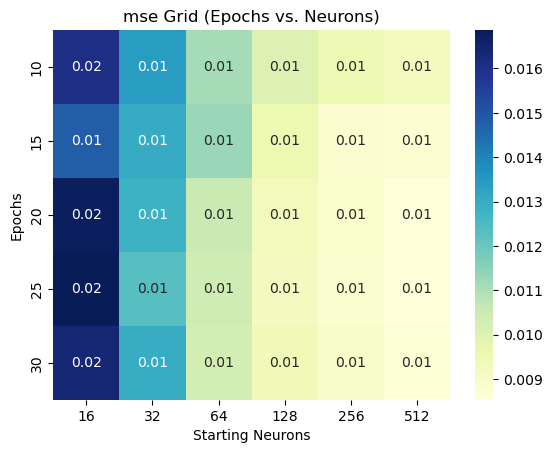

In [132]:
## heat map code for mse
sns.heatmap(formatedResultsMSE, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("mse Grid (Epochs vs. Neurons)")
plt.ylabel("Epochs")
plt.xlabel("Starting Neurons")
plt.show()

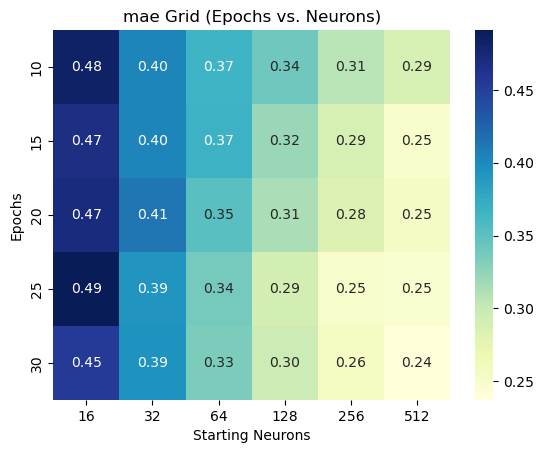

In [107]:
## heat map code for mae
sns.heatmap(formatedResultsMAE, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("mae Grid (Epochs vs. Neurons)")
plt.ylabel("Epochs")
plt.xlabel("Starting Neurons")
plt.show()

In [134]:
#formatedResults
best = results.loc[results['mse'].idxmin()]
print(f"Best config: epochs={best['epochs']}, neurons={best['neurons']}, mse={best['mse']}")

Best config: epochs=25, neurons=512, mse=0.008532663807272911


In [162]:
## the best model
bestModel = Sequential()

# Input layer 
bestModel.add(Input(shape=(42,)))
bestModel.add(Dense(best['neurons'], activation='relu'))

# 1st Hidden layer
bestModel.add(Dense(int(best['neurons']/2), activation='relu'))
bestModel.add(Dropout(0.5))  

# 2nd Hidden layer 
bestModel.add(Dense(int(best['neurons']/4), activation='relu'))
bestModel.add(Dropout(0.5))  

# Output layer 1 neurons for score of vals range of -1 to 1 
bestModel.add(Dense(1, activation='tanh'))



bestModel.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'mse'])
model.fit(XInitalTrain, yInitalTrain, epochs=best['epochs'], batch_size=32, validation_split=0.2 class_weight = {1.0:100.0, 0.0:1.0, -1.0:100.0}) # training on absolte wins/losses fisrt so the model knows what it is 
history = bestModel.fit(XTrain, yTrain, epochs=best['epochs'], batch_size=32, validation_split=0.2, class_weight=classWeightsDict)
bestModel.summary()

# Plotting Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1582367150.py, line 22)

In [146]:
#testing 
lossI, maeI, mseI = model.evaluate(XInitalTrain, yInitalTrain)

loss, mae, mse = model.evaluate(XTest, yTest)
## adding to data stucture 
newResult = {'epochs': epochVal, 'neurons': best['neurons'], 'mae': mae ,'mse': mse, 'maeI': lossI ,'mseI': mseI  }
print(newResult)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3832e-07 - mae: 5.5585e-05 - mse: 5.3832e-07
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.7626 - mae: 0.8222 - mse: 0.7626
{'epochs': 35, 'neurons': 512, 'mae': 0.8195868730545044, 'mse': 0.7595402598381042, 'maeI': 6.291473937380943e-07, 'mseI': 6.291473937380943e-07}


In [154]:
#tests for game agent
winBoard = [
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, 1, 1, 1, 0, 0, 0
]

loseBoard = [
    0, 0, 0, 0, 0, 0, 0,
    0,  0,  0, 0, 0, 0, 0,
    0,  0,  0, 0, 0, 0, 0,
    0,  0,  0, 0, 0, 0, 0,
    0,  0,  0, 0, 0, 0, 0,
    -1,  -1,  -1, 0, 0, 0, 0
]

drawBoard = [ # wrong 
    1, -1, 1, -1, 1, -1, 1,
    -1, 1, -1, 1, -1, 1, -1,
    1, -1, 1, -1, 1, -1, 1,
    -1, 1, -1, 1, -1, 1, -1,
    1, -1, 1, -1, 1, -1, 1,
    -1, 1, -1, 1, -1, 1, -1
]

midgameBoard = [
    0,  0,  0,  0,  0,  0,  0,
    0,  0,  0,  0,  0,  0,  0,
    0,  0,  1, -1,  0,  0,  0,
    0,  1, -1,  1,  0,  0,  0,
    -1, -1,  1, -1,  0,  0,  0,
    1,  1, -1,  1,  0,  0,  0
]
boards = [winBoard, loseBoard, drawBoard, midgameBoard]
for i, board in enumerate(boards):
    pred = bestModel.predict(np.array([board]))[0][0]
    print(f"Board {i+1} prediction: {pred:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Board 1 prediction: -0.199
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Board 2 prediction: 0.187
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Board 3 prediction: 0.182
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Board 4 prediction: 0.191


In [142]:
preds = model.predict(XTest).flatten()
print(np.min(preds), np.max(preds), np.mean(preds))
#print(np.histogram(preds, bins=10))

for val in [-1.0, 0.0, 1.0]:
    groupPreds = preds[yTest == val]
    print(f"True {val}:")
    print(f"  Mean prediction = {np.mean(groupPreds):.3f}")
    print(f"  Std. deviation  = {np.std(groupPreds):.3f}")
    print(f"  Sample count    = {len(groupPreds)}")

423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
-1.0 1.0 -0.2869736
True -1.0:
  Mean prediction = nan
  Std. deviation  = nan
  Sample count    = 0
True 0.0:
  Mean prediction = -0.432
  Std. deviation  = 0.729
  Sample count    = 1295
True 1.0:
  Mean prediction = nan
  Std. deviation  = nan
  Sample count    = 0


D:\Program Files\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Program Files\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
D:\Program Files\Anaconda\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\Program Files\Anaconda\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
D:\Program Files\Anaconda\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [144]:
bestModel.save("Models/NeuaralNetworkLR_Connect4.h5")